# Andmete simuleerimine

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from sklearn.linear_model import LogisticRegression

In [2]:
# Indviidide arv
n = 1000
np.random.seed(999)

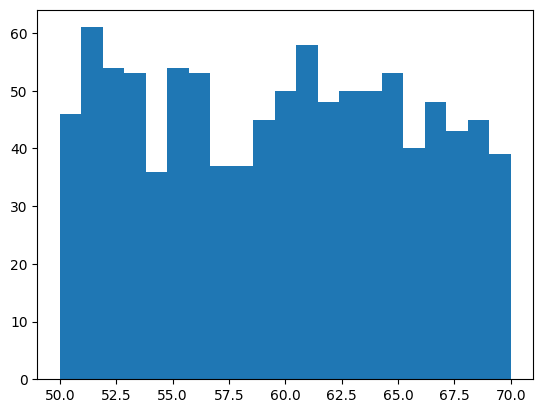

In [3]:
#Vanus

# Vanuse jaotuse andmed
age_dist = pd.read_csv("vanuste50-70-arv-Eestis2024.csv", skiprows=2)
#age_dist.head()

# Genereerime vanused
age_dist['prop'] = age_dist['Kogu Eesti 2024'] / age_dist['Kogu Eesti 2024'].sum()
age = np.random.choice(age_dist['Vanus'], n, p=age_dist['prop'])

plt.hist(age, bins = 21)
plt.show()

In [4]:
# Sugu

# Soo jaotuse andmed
sex_dist = pd.read_csv("mehed-naised-jaotus.csv", skiprows=2)
sex_dist['M_prop'] = sex_dist['Mehed 2024'] / (sex_dist['Mehed 2024'] + sex_dist['Naised 2024'])

# Genereerime soo vastavalt vanusele
sex = np.array([np.random.choice(['Male', 'Female'], p=[sex_dist.loc[sex_dist['Vanus'] == a, 'M_prop'].values[0], 1 - sex_dist.loc[sex_dist['Vanus'] == a, 'M_prop'].values[0]]) for a in age])
print(pd.DataFrame({'age': age, 'sex': sex}).groupby('sex')['age'].describe())

        count       mean       std   min    25%   50%   75%   max
sex                                                              
Female  520.0  60.209615  6.062957  50.0  55.00  60.0  65.0  70.0
Male    480.0  59.239583  5.983528  50.0  53.75  59.0  64.0  70.0


In [5]:
# Füüsiline aktiivsus
def prob_physical_activity(age):
    if age < 60:
        return [0.2, 0.5, 0.3]  # Tõenäosused low, moderate, high
    else:
        return [0.4, 0.4, 0.2]

physical_activity = np.array([np.random.choice(["Low", "Moderate", "High"], p=prob_physical_activity(a)) for a in age])
pd.Series(physical_activity).value_counts()

Moderate    475
Low         297
High        228
Name: count, dtype: int64

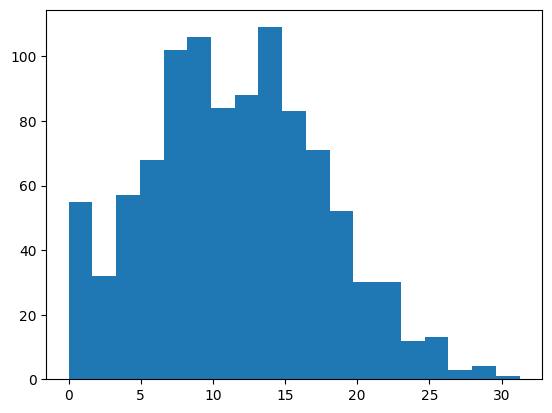

In [6]:
# Alkohol
def prob_alcohol_units(age, sex, activity):
    if sex == "Male":
        if activity == "Low":
            base_units = 20
        elif activity == "Moderate":
            base_units = 15
        else:
            base_units = 10
    else:
        if activity == "Low":
            base_units = 15
        elif activity == "Moderate":
            base_units = 10
        else:
            base_units = 5
    
    age_factor = 1 if age < 60 else 0.8
    return max(np.random.normal(base_units * age_factor, 5), 0)

alcohol_units = np.array([prob_alcohol_units(a, s, p) for a, s, p in zip(age, sex, physical_activity)])
plt.hist(alcohol_units, bins = 'auto')
plt.show()

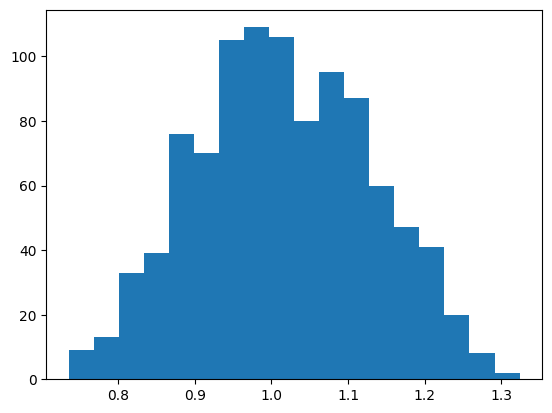

In [7]:
# WHR
def prob_whr(age, sex, alcohol, activity):
    base_whr = 0.9 if sex == "Male" else 0.8
    alcohol_factor = 0.01 * alcohol
    activity_factor = 0.05 if activity == "Low" else (-0.05 if activity == "High" else 0)
    age_factor = 0.005 * (age - 50)
    return base_whr + alcohol_factor + activity_factor + age_factor + np.random.normal(0, 0.02)

whr = np.array([prob_whr(a, s, alc, act) for a, s, alc, act in zip(age, sex, alcohol_units, physical_activity)])
plt.hist(whr, bins = 'auto')
plt.show()

In [8]:
# Maksatsirroos
def prob_cirrhosis(whr, alcohol, activity, age, sex):
    base_risk = 0.1 if sex == "Male" else 0.05
    whr_factor = 0.05 * whr
    #alcohol_factor = 0.01 * alcohol
    alcohol_factor = 0.01 * alcohol
    activity_factor = 0.05 if activity == "Low" else (-0.05 if activity == "High" else 0)
    age_factor = 0.005 * (age - 50)
    risk = base_risk + whr_factor + alcohol_factor + activity_factor + age_factor
    return np.random.binomial(1, risk)

cirrhosis = np.array([prob_cirrhosis(w, alc, act, a, s) for w, alc, act, a, s in zip(whr, alcohol_units, physical_activity, age, sex)])
pd.Series(cirrhosis).value_counts()

0    741
1    259
Name: count, dtype: int64

In [9]:
# Maksa siirdamine
def prob_liver_transplant(alcohol, age, cirrhosis):
    base_risk = 0.3 if cirrhosis == 1 else 0.01
    alcohol_factor = 0.02 * alcohol
    age_factor = 0.05 if age > 60 else 0
    risk = base_risk + alcohol_factor + age_factor
    return np.random.binomial(1, risk)

liver_transplant = np.array([prob_liver_transplant(alc, a, c) for alc, a, c in zip(alcohol_units, age, cirrhosis)])
pd.Series(liver_transplant).value_counts()

0    657
1    343
Name: count, dtype: int64

In [10]:
# Koostame andmestiku
data = pd.DataFrame({
    'age': age,
    'sex': sex,
    'physical_activity': physical_activity,
    'alcohol_units': alcohol_units,
    'whr': whr,
    'cirrhosis': cirrhosis,
    'liver_transplant': liver_transplant
})

print(data.head())

   age     sex physical_activity  alcohol_units       whr  cirrhosis  \
0   66    Male          Moderate       8.988626  1.063755          0   
1   60    Male          Moderate       8.932392  1.058569          0   
2   52  Female          Moderate      14.657677  0.945773          1   
3   63    Male               Low      16.057751  1.189715          0   
4   51  Female              High       0.000000  0.744882          0   

   liver_transplant  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  


In [11]:
# Salvestame andmestiku
data.to_csv('simulated_data.csv', index=False)

# Testimine

### Bayes

In [12]:
sex_dummy = pd.get_dummies(data['sex'], drop_first=True).astype(int)
physical_activity_dummy = pd.get_dummies(data['physical_activity'], drop_first=True).astype(int)

df = pd.DataFrame({
    'alcohol' : alcohol_units,
    'sex': sex_dummy["Male"],
    'age': age,
    'physical_activity_low' : physical_activity_dummy["Low"],
    'physical_activity_moderate' : physical_activity_dummy["Moderate"],
    'cirrhosis': cirrhosis 
})

# Tunnuste standardiseerimine
df["alcohol_std"] = (df["alcohol"] - df["alcohol"].mean()) / df["alcohol"].std()
df["age_std"] = (df["age"] - df["age"].mean()) / df["age"].std()

In [13]:
with pm.Model() as model:
    # Priors on coefficients (including intercept)
    a = pm.Normal("intercept", mu=0, sigma=10)
    b1 = pm.Normal("alc_coef", mu=0, sigma=10)
    b2 = pm.Normal("male_coef", mu=0, sigma=10)
    b3 = pm.Normal("age_coef", mu=0, sigma=10)
    b4 = pm.Normal("pa_low_coef", mu=0, sigma=10)
    b5 = pm.Normal("pa_moderate_coef", mu=0, sigma=10)
    # Logistic regression
    p = pm.math.sigmoid(a + 
                        b1*df['alcohol_std'] + 
                        b2*df['sex'] + 
                        b3*df['age_std'] + 
                        b4*df['physical_activity_low'] +
                        b5*df['physical_activity_moderate'])
    y_obs = pm.Bernoulli("cirrhosis", p=p, observed=df['cirrhosis'])

    # Sampling
    trace = pm.sample()
    #trace = pm.sample(accept=0.9, draws=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, alc_coef, male_coef, age_coef, pa_low_coef, pa_moderate_coef]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.


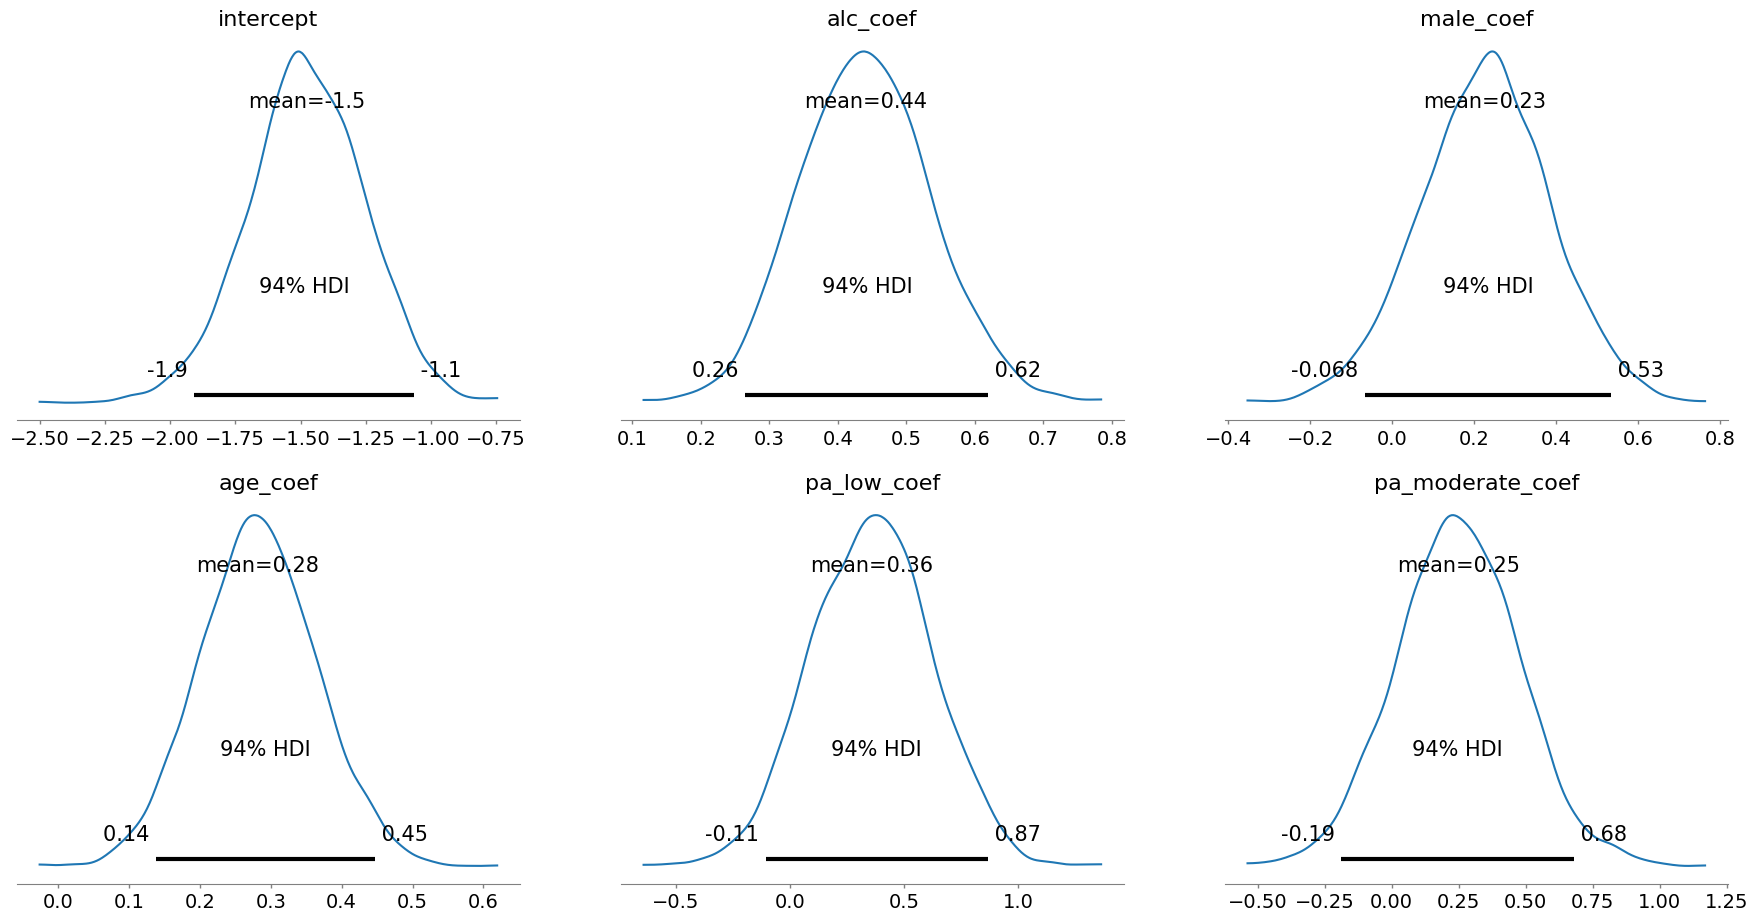

In [14]:
import arviz as az, matplotlib.pyplot as plt
az.plot_posterior(trace)
plt.show()

In [15]:
#print(pm.summary(trace))
az.summary(trace, var_names=["intercept", "alc_coef", "male_coef", "age_coef", "pa_low_coef", "pa_moderate_coef"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-1.477,0.224,-1.907,-1.064,0.006,0.004,1417.0,2116.0,1.0
alc_coef,0.440,0.096,0.265,0.620,0.002,0.001,2429.0,2808.0,1.0
male_coef,0.226,0.159,-0.068,0.534,0.003,0.002,2668.0,2671.0,1.0
age_coef,0.282,0.082,0.138,0.447,0.001,0.001,3491.0,2630.0,1.0
pa_low_coef,0.358,0.264,-0.106,0.865,0.007,0.005,1413.0,1907.0,1.0
pa_moderate_coef,0.248,0.231,-0.188,0.680,0.006,0.004,1445.0,1990.0,1.0


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'alc_coef'}>,
        <Axes: title={'center': 'alc_coef'}>],
       [<Axes: title={'center': 'male_coef'}>,
        <Axes: title={'center': 'male_coef'}>],
       [<Axes: title={'center': 'age_coef'}>,
        <Axes: title={'center': 'age_coef'}>],
       [<Axes: title={'center': 'pa_low_coef'}>,
        <Axes: title={'center': 'pa_low_coef'}>],
       [<Axes: title={'center': 'pa_moderate_coef'}>,
        <Axes: title={'center': 'pa_moderate_coef'}>]], dtype=object)

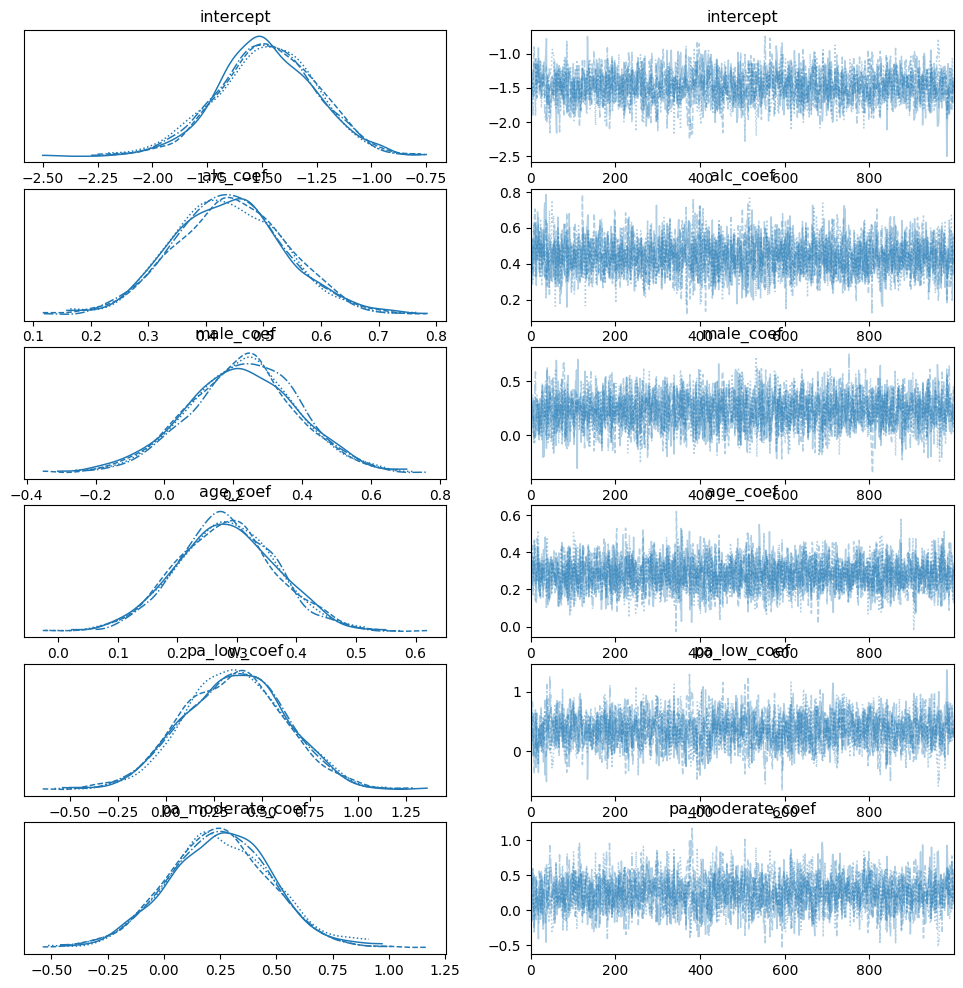

In [16]:
pm.plot_trace(trace)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

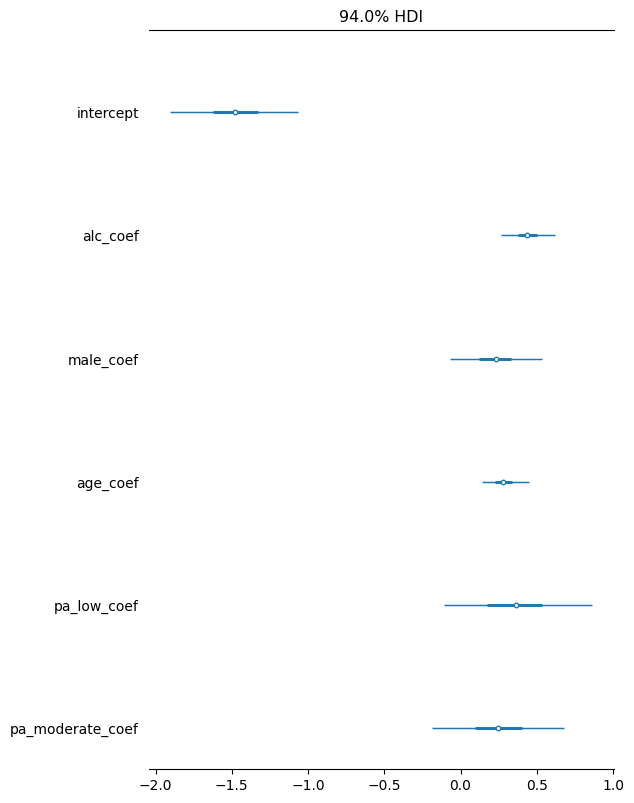

In [17]:
az.plot_forest(trace, var_names=["intercept","alc_coef", "male_coef", "age_coef", "pa_low_coef", "pa_moderate_coef"], combined=True, textsize=10)